In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import os


2024-04-15 12:09:50.810323: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 12:09:50.810472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 12:09:50.963271: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define dataset path
dataset_path = "/kaggle/input/maize-disease/Model"


# Initialize the ImageDataGenerator for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

# Load dataset with flow_from_directory
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224), # Size for VGG16
    batch_size=32,
    class_mode='categorical') # For multi-class classification


Found 15349 images belonging to 4 classes.


In [3]:
# Display each folder name

a=0
for class_name in os.listdir(dataset_path):
    a=a+1
    print(a,class_name)


1 MLN
2 HEATHLY
3 MSV_2
4 MSV_1


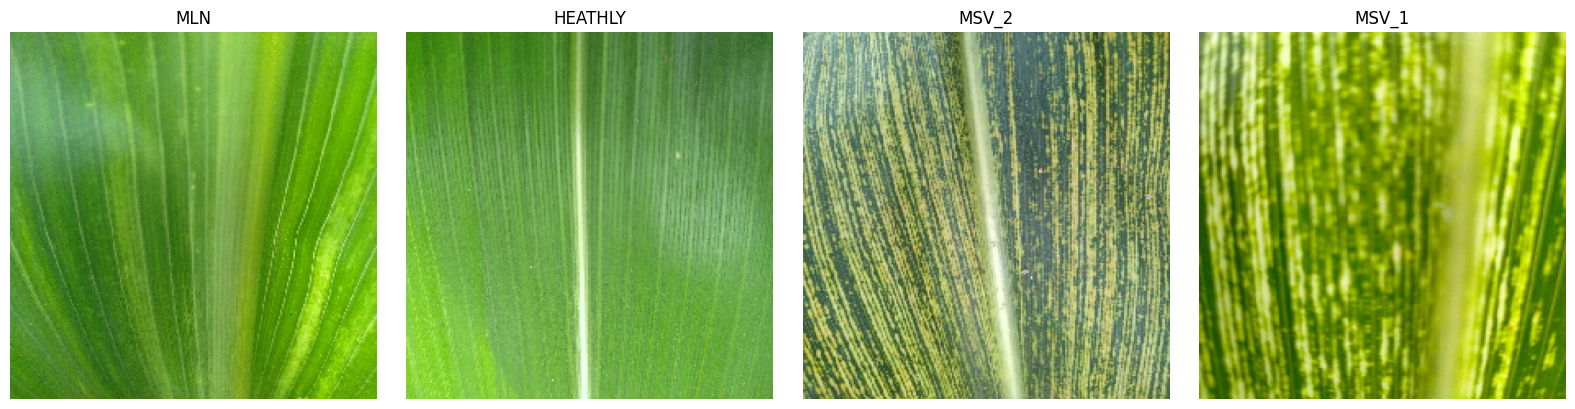

In [4]:
import matplotlib.pyplot as plt

# Function to display one image from each class in landscape orientation
def display_images_in_landscape(dataset_path):
    # Determine the number of classes
    num_classes = len(os.listdir(dataset_path))
    plt.figure(figsize=(num_classes * 4, 4)) # Adjust the figure size as needed

    for i, class_folder in enumerate(os.listdir(dataset_path), start=1):
        class_folder_path = os.path.join(dataset_path, class_folder)
        first_image = os.listdir(class_folder_path)[0]
        img_path = os.path.join(class_folder_path, first_image)
        img = load_img(img_path, target_size=(224, 224))
        plt.subplot(1, num_classes, i)
        plt.imshow(img)
        plt.title(class_folder)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_images_in_landscape(dataset_path)

In [5]:
import os

# Define dataset path
dataset_path = "/kaggle/input/maize-disease/Model"

# Count the number of images per class
image_counts = {}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    # Ensure the path is a directory to avoid file counting
    if os.path.isdir(class_path):
        image_counts[class_name] = len(os.listdir(class_path))

print(image_counts)


{'MLN': 3980, 'HEATHLY': 5117, 'MSV_2': 3095, 'MSV_1': 3157}


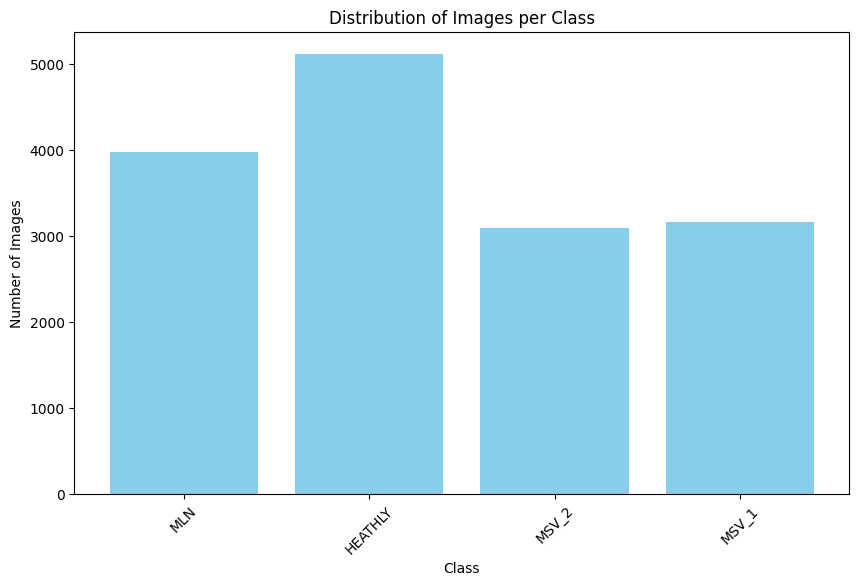

In [6]:
import matplotlib.pyplot as plt

# Data
classes = list(image_counts.keys())
counts = list(image_counts.values())

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class')
plt.xticks(rotation=45) # Rotate class names for better readability
plt.show()


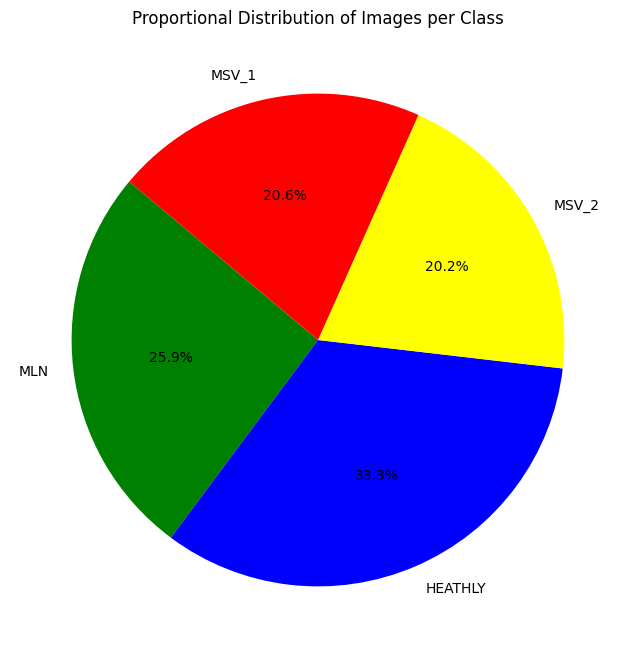

In [7]:
# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=140, colors=['green', 'blue', 'yellow', 'red'])
plt.title('Proportional Distribution of Images per Class')
plt.show()

**AUGMENTATION USING ImageDataGenerator**

In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Set data directory and image specifications
data_dir = "/kaggle/input/maize-disease/Model"
img_height, img_width = 224, 224  # Dimensions VGG16 expects
batch_size = 32

# ImageDataGenerator with augmentation for the training data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Splitting data: 80% train, 20% validation
)

# Validation data should not be augmented
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# Create generators for training and validation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Set as training data
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

# Load InceptionV3 model for Transfer Learning
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze all layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Compile the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10  # Adjust epochs based on your dataset size
)

# Evaluate the model on the validation set
evaluation = model.evaluate(validation_generator)
print('Loss on validation set:', evaluation[0])
print('Accuracy on validation set:', evaluation[1])


Found 12280 images belonging to 4 classes.
Found 3069 images belonging to 4 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/383 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.1484 - loss: 4.5885   

I0000 00:00:1713183045.173667     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


383/383 ━━━━━━━━━━━━━━━━━━━━ 332s 796ms/step - accuracy: 0.6596 - loss: 1.3009 - val_accuracy: 0.7312 - val_loss: 0.6486
Epoch 2/10
  1/383 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.6562 - loss: 0.6471

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6562 - loss: 0.6471 - val_accuracy: 0.8276 - val_loss: 0.4894
Epoch 3/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 210s 540ms/step - accuracy: 0.7951 - loss: 0.5058 - val_accuracy: 0.7398 - val_loss: 0.5938
Epoch 4/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.8125 - loss: 0.4293 - val_accuracy: 0.7586 - val_loss: 0.5436
Epoch 5/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 207s 533ms/step - accuracy: 0.8182 - loss: 0.4566 - val_accuracy: 0.7576 - val_loss: 0.5631
Epoch 6/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.9062 - loss: 0.3108 - val_accuracy: 0.7241 - val_loss: 0.5983
Epoch 7/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 206s 529ms/step - accuracy: 0.8276 - loss: 0.4328 - val_accuracy: 0.7273 - val_loss: 0.6331
Epoch 8/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - accuracy: 0.8125 - loss: 0.4778 - val_accuracy: 0.7241 - val_loss: 0.5890
Epoch 9/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 207s 532ms/step - accuracy: 0.8265 - loss: 0.4209 - val_

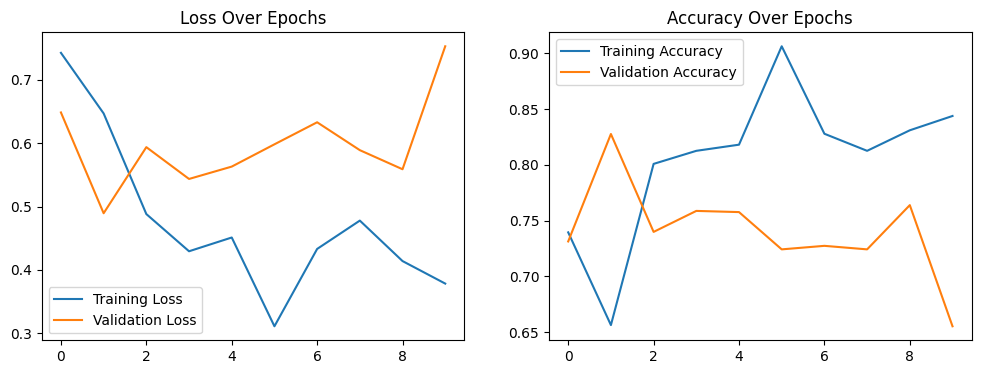

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

In [12]:
from sklearn.metrics import classification_report
import numpy as np

# Ensure the generator does not shuffle the data
validation_generator.shuffle = False

# Reset the generator to ensure the predictions correspond to the input labels
validation_generator.reset()

# Predict the classes for the validation set
y_pred = model.predict(validation_generator, steps=validation_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class labels
y_true = validation_generator.classes

# Get the class labels for the classification report
class_labels = list(validation_generator.class_indices.keys())

# Generate and print the classification report, ensuring class names appear
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 192ms/step
              precision    recall  f1-score   support

     HEATHLY       0.87      0.99      0.93      1023
         MLN       0.89      0.74      0.81       796
       MSV_1       0.54      0.71      0.61       631
       MSV_2       0.67      0.44      0.53       619

    accuracy                           0.76      3069
   macro avg       0.74      0.72      0.72      3069
weighted avg       0.77      0.76      0.75      3069



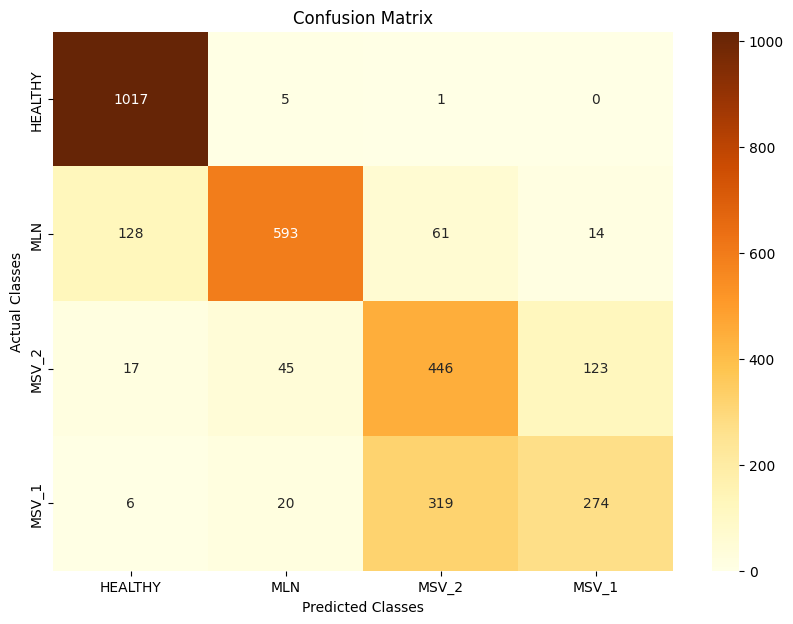

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Define the names of the target classes
target_names = ['HEALTHY', 'MLN', 'MSV_2', 'MSV_1']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrBr", xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()


BEFORE AUGMENATION

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Set data directory and image specifications
data_dir = "/kaggle/input/maize-disease/Model"
img_height, img_width = 224, 224  # Dimensions VGG16 expects
batch_size = 32

# ImageDataGenerator without augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2  # Splitting data: 80% train, 20% validation
)

# Create generators for training and validation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Set as training data
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

# Load InceptionV3 model for Transfer Learning
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze all layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Compile the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10  # Adjust epochs based on your dataset size
)

# Evaluate the model on the validation set
evaluation = model.evaluate(validation_generator)
print('Loss on validation set:', evaluation[0])
print('Accuracy on validation set:', evaluation[1])


Found 12280 images belonging to 4 classes.
Found 3069 images belonging to 4 classes.
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


383/383 ━━━━━━━━━━━━━━━━━━━━ 121s 277ms/step - accuracy: 0.6897 - loss: 1.2081 - val_accuracy: 0.7888 - val_loss: 0.4694
Epoch 2/10
  1/383 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.8125 - loss: 0.4240

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8125 - loss: 0.4240 - val_accuracy: 0.8276 - val_loss: 0.3874
Epoch 3/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 94s 243ms/step - accuracy: 0.8512 - loss: 0.3809 - val_accuracy: 0.7941 - val_loss: 0.4956
Epoch 4/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - accuracy: 0.7812 - loss: 0.5693 - val_accuracy: 0.7241 - val_loss: 0.7535
Epoch 5/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 95s 245ms/step - accuracy: 0.8727 - loss: 0.3223 - val_accuracy: 0.8053 - val_loss: 0.4848
Epoch 6/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - accuracy: 0.9062 - loss: 0.3162 - val_accuracy: 0.8966 - val_loss: 0.3311
Epoch 7/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 96s 246ms/step - accuracy: 0.8902 - loss: 0.2795 - val_accuracy: 0.8066 - val_loss: 0.4588
Epoch 8/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - accuracy: 0.9375 - loss: 0.1682 - val_accuracy: 0.7931 - val_loss: 0.5128
Epoch 9/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 94s 243ms/step - accuracy: 0.9030 - loss: 0.2414 - val_accur

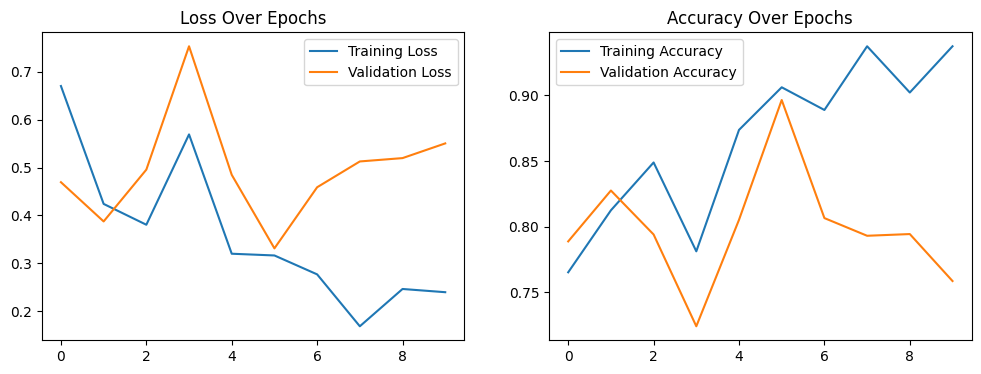

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

In [17]:
from sklearn.metrics import classification_report
import numpy as np

# Ensure the generator does not shuffle the data
validation_generator.shuffle = False

# Reset the generator to ensure the predictions correspond to the input labels
validation_generator.reset()

# Predict the classes for the validation set
y_pred = model.predict(validation_generator, steps=validation_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class labels
y_true = validation_generator.classes

# Get the class labels for the classification report
class_labels = list(validation_generator.class_indices.keys())

# Generate and print the classification report, ensuring class names appear
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step
              precision    recall  f1-score   support

     HEATHLY       0.99      0.95      0.97      1023
         MLN       0.88      0.91      0.90       796
       MSV_1       0.55      0.80      0.65       631
       MSV_2       0.70      0.38      0.50       619

    accuracy                           0.80      3069
   macro avg       0.78      0.76      0.75      3069
weighted avg       0.81      0.80      0.79      3069



96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 193ms/step


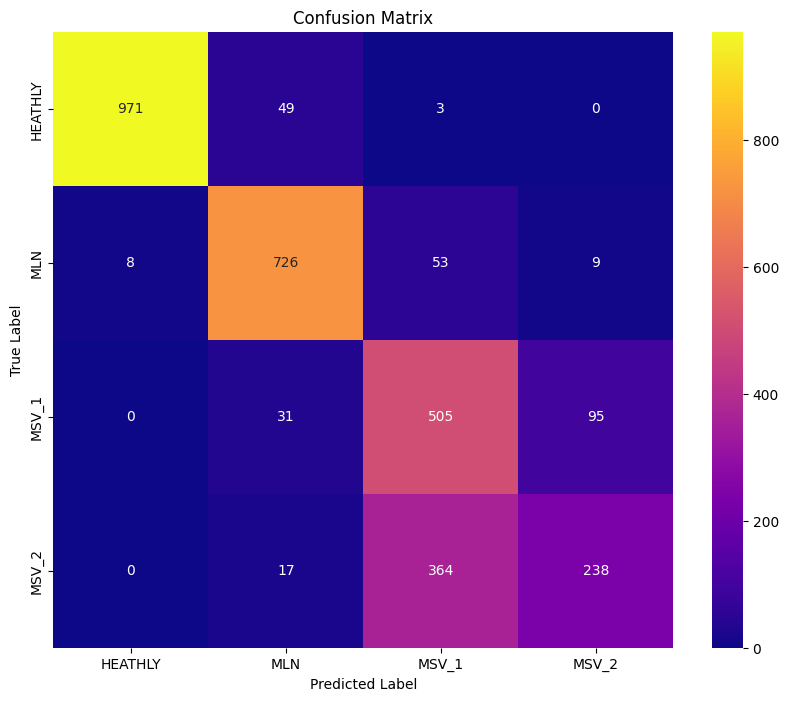

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.vgg16 import preprocess_input

# Ensure the generator does not shuffle data to match labels with predictions
validation_generator.shuffle = False

# Reset the validation generator
validation_generator.reset()

# Predicting the whole validation set
Y_pred = model.predict(validation_generator, steps=validation_steps)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = validation_generator.classes

# Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

# Class labels
class_labels = list(validation_generator.class_indices.keys())

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="plasma", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


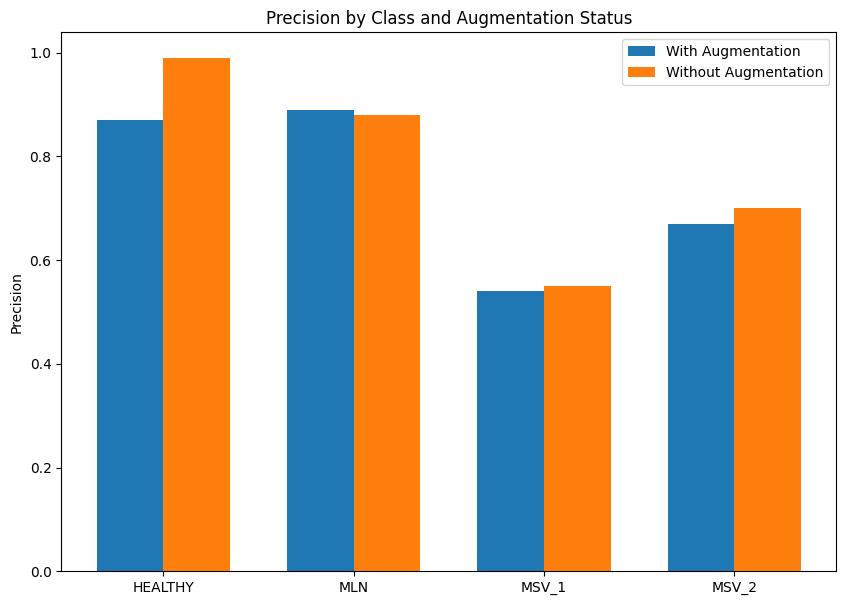

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Define the class labels and performance metrics from the classification reports
labels = ['HEALTHY', 'MLN', 'MSV_1', 'MSV_2']
# Updated precision values from screenshots
precision_with_aug = [0.87, 0.89, 0.54, 0.67]
precision_without_aug = [0.99, 0.88, 0.55, 0.70]
# Other metrics appear to be the same as what you've already defined
recall_with_aug = [0.99, 0.74, 0.71, 0.44]
recall_without_aug = [0.95, 0.91, 0.80, 0.38]
f1_with_aug = [0.93, 0.81, 0.61, 0.53]
f1_without_aug = [0.97, 0.90, 0.65, 0.50]
support = [1023, 796, 631, 619]
# Updated accuracy values from screenshots
accuracy_with_aug = 0.76  # Accuracy with augmentation from the second screenshot
accuracy_without_aug = 0.80  # Accuracy without augmentation from the first screenshot

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Precision Comparison
plt.figure(figsize=(10, 7))
plt.bar(x - width/2, precision_with_aug, width, label='With Augmentation')
plt.bar(x + width/2, precision_without_aug, width, label='Without Augmentation')
plt.ylabel('Precision')
plt.title('Precision by Class and Augmentation Status')
plt.xticks(x, labels)
plt.legend()
plt.show()


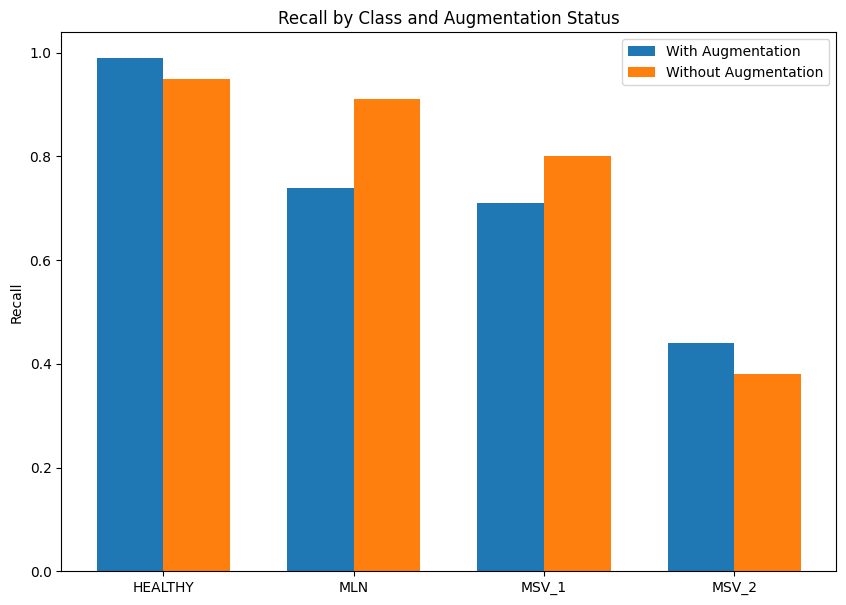

In [20]:
# Recall Comparison
plt.figure(figsize=(10, 7))
plt.bar(x - width/2, recall_with_aug, width, label='With Augmentation')
plt.bar(x + width/2, recall_without_aug, width, label='Without Augmentation')
plt.ylabel('Recall')
plt.title('Recall by Class and Augmentation Status')
plt.xticks(x, labels)
plt.legend()
plt.show()


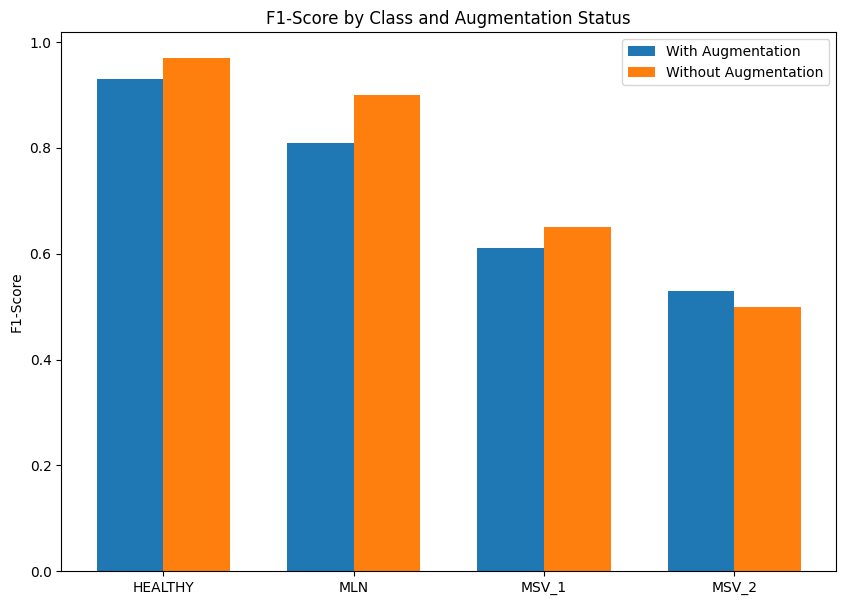

In [21]:
# F1-Score Comparison
plt.figure(figsize=(10, 7))
plt.bar(x - width/2, f1_with_aug, width, label='With Augmentation')
plt.bar(x + width/2, f1_without_aug, width, label='Without Augmentation')
plt.ylabel('F1-Score')
plt.title('F1-Score by Class and Augmentation Status')
plt.xticks(x, labels)
plt.legend()
plt.show()


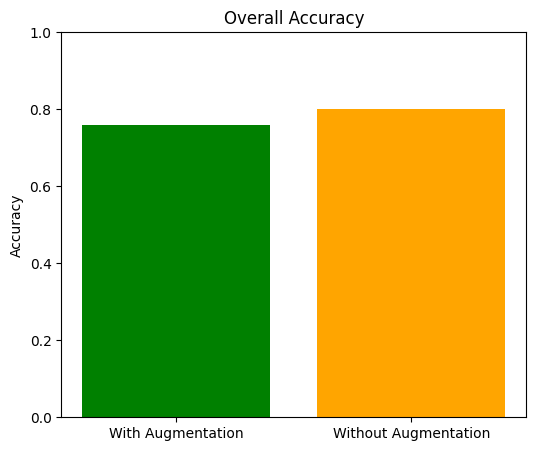

In [23]:
import matplotlib.pyplot as plt

# Overall Accuracy Comparison
plt.figure(figsize=(6, 5))
categories = ['With Augmentation', 'Without Augmentation']
accuracy_values = [accuracy_with_aug, accuracy_without_aug]  # Use the correct variable names
plt.bar(categories, accuracy_values, color=['green', 'orange'])
plt.ylabel('Accuracy')
plt.title('Overall Accuracy')
plt.ylim(0, 1)  # Optional: Define limits of y-axis to see the difference better if accuracy is high
plt.show()
